In [7]:
!pip install pytorch-tabnet catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 23.0 MB/s eta 0:00:00


In [32]:
import joblib
from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostRegressor

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/prepared_data.csv')

# Define independent (X) and dependent (y) variables
X = df.drop(columns=['Target'])  # Drop the target column
y = df['Target']  # Target variable

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [45]:
# Load CatBoost model
catboost_model = joblib.load("catboost_balanced.joblib")

# Load TabNet model
tabnet_model = TabNetClassifier()
tabnet_model.load_model("tabnet_model.zip")

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

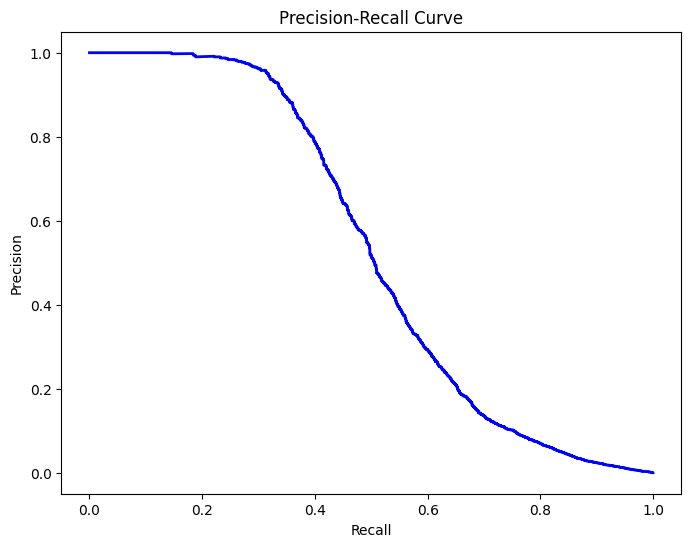

In [46]:
# Get predictions (probabilities)
tabnet_preds = tabnet_model.predict_proba(X_test.values)[:, 1]
catboost_preds = catboost_model.predict_proba(X_test.values)[:, 1]

# Stack the predictions as new features
X_meta = np.column_stack((tabnet_preds, catboost_preds))

# Train meta-learner using validation data
meta_learner = LogisticRegression()
meta_learner.fit(X_meta, y_test.values)

# Get final stacked predictions
meta_preds_proba = meta_learner.predict_proba(X_meta)[:, 1]
meta_preds = (meta_preds_proba > 0.5).astype(int)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, meta_preds_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [47]:
# Calculate F1 scores for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the best threshold based on F1 score
best_threshold = thresholds[f1_scores.argmax()]

# Print the best threshold
print("Best Threshold:", best_threshold)

# Apply the best threshold for classification
meta_pred_adj = (meta_preds_proba >= best_threshold).astype(int)

# Evaluate the performance
print(classification_report(y_test.values, meta_pred_adj))

Best Threshold: 0.48402864973486814
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1780327
           1       0.69      0.44      0.54      2666

    accuracy                           1.00   1782993
   macro avg       0.84      0.72      0.77   1782993
weighted avg       1.00      1.00      1.00   1782993

